## EM estimation of missing marks in an exam setting
Linear model
$X_{ij} = c + \beta_i + \gamma_j + \epsilon_{ij}$

where $X_{ij}$ is the mark of student $i$ in exam $j$
we are aiming to estimate student effects $\beta_i$ and problem effects $\gamma_j$

In [ ]:
import pandas as pd
import numpy as np

#import random generator
rng = np.random.default_rng(seed=42)



#simulate data
Ns = 60
Np = 24

# student and problem parameters
a = rng.normal(loc=0, scale=2, size=Ns)
b = rng.uniform(-3,3, size=Np)

eps = rng.normal(loc=0, scale=1.5, size=Ns*Np)
eps = eps.reshape(Ns, Np)
X = 3.5 + a[:, np.newaxis] + b[np.newaxis, :] + eps

X = np.clip(np.round(X), 0, 6)

X_missing = X.astype(float)
# 1. Randomly shuffle student indices to form 3 equal groups
student_indices = rng.permutation(Ns)
groups = np.split(student_indices, 3)
# 2. Apply the censoring pattern
for i in range(3):
    # Columns to censor for group i: 8*i, 8*i+1, ..., 8*i+7
    start_col = 8 * i
    end_col = 8 * (i + 1)
    
    # Set the block to NaN for these students
    X_missing[groups[i], start_col:end_col] = np.nan
# Verify the result
print(f"Total missing values: {np.isnan(X_missing).sum()} out of {X.size}={Ns}*{Np}")
# Should be 20 * 8 * 3 = 480





Total missing values: 480 out of 1440=60*24


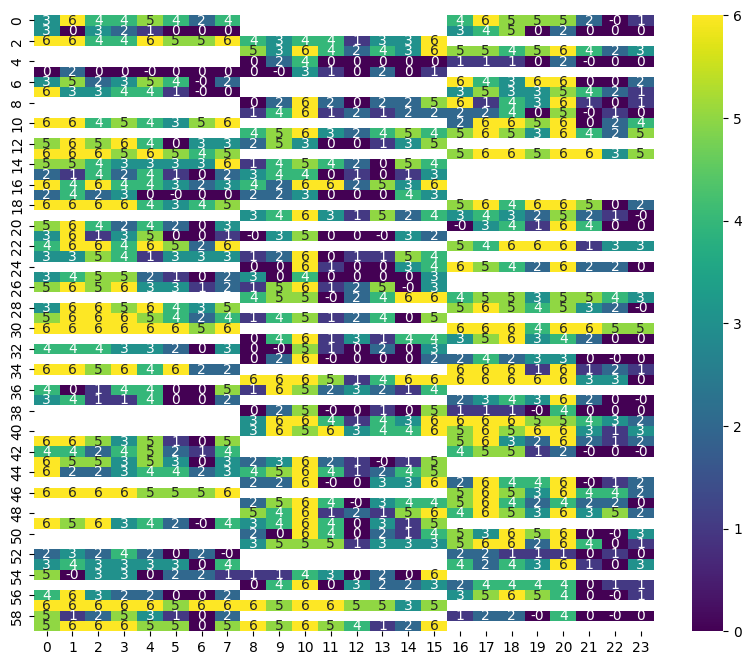

In [10]:
#show X matrix nicely with a heatmap overlayed
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(X_missing, annot=True, cmap='viridis')
plt.show()


In [ ]:
def regularized_em_ranking(X_in, reg_lambda=1.0, max_iter=100, tol=1e-4):
    """
    Regularized EM (ALS) with step-by-step progress logging.
    """
    X = X_in.copy()
    n_students, n_problems = X.shape
    
    # Step 0: Initialization
    mu = np.nanmean(X)
    theta = np.zeros(n_students)
    beta = np.zeros(n_problems)
    
    # Pre-calculate masks and counts (avoids doing this in the loop)
    observed_mask = ~np.isnan(X)
    n_obs_student = np.sum(observed_mask, axis=1)
    n_obs_problem = np.sum(observed_mask, axis=0)
    print(f"--- Starting EM Optimization ---")
    print(f"Matrix: {n_students}x{n_problems}, mu: {mu:.3f}, lambda: {reg_lambda}")
    
    for iteration in range(1, max_iter + 1):
        theta_old = theta.copy()
        beta_old = beta.copy()
        
        # 1. Update Student Ability (Theta)
        # Residual = X - mu - beta
        res_theta = X - mu - beta[np.newaxis, :]
        theta = np.nansum(res_theta, axis=1) / (n_obs_student + reg_lambda)
        
        # 2. Update Problem Easiness (Beta)
        # Residual = X - mu - theta
        res_beta = X - mu - theta[:, np.newaxis]
        beta = np.nansum(res_beta, axis=0) / (n_obs_problem + reg_lambda)
        
        # --- Calculate Progress Metrics ---
        theta_diff = np.linalg.norm(theta - theta_old)
        beta_diff = np.linalg.norm(beta - beta_old)
        
        # Optional: Calculate RMSE on observed values to track "goodness of fit"
        current_pred = mu + theta[:, np.newaxis] + beta[np.newaxis, :]
        observed_errors = (X[observed_mask] - current_pred[observed_mask])**2
        rmse = np.sqrt(np.mean(observed_errors))
        
        print(f"Iter {iteration:2d} | d_theta: {theta_diff:.5f} | d_beta: {beta_diff:.5f} | RMSE: {rmse:.5f}")
        
        # Convergence Check
        if theta_diff < tol and beta_diff < tol:
            print(f"--- Converged at iteration {iteration} ---")
            break
    else:
        print(f"--- Reached max_iter ({max_iter}) without full convergence ---")
            
    # Final Imputed Output
    X_filled = np.clip(mu + theta[:, np.newaxis] + beta[np.newaxis, :], 0, 6)
    
    return theta, beta, X_filled, mu

In [ ]:
theta, beta, X_filled, mu = regularized_em_ranking(X_missing, reg_lambda=1, max_iter=100, tol=1e-6)
